In [65]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Illuminati Map

Jacob Smilg and Markus Leschly

Software Design Midterm Project, Spring 2021

## Introduction:
When finding topics to research for this project, we became interested in seeing how the most viewed people on Wikipedia’s pages were connected. However, we quickly realized we needed a rather small category to focus on specifically. We decided to proceed with the [American billionaires category](https://en.wikipedia.org/wiki/Category:American_billionaires) since we expect it to be a highly interconnected group, with many possible interesting connections. We also assumed that the most interesting connections would likely occur between the most viewed pages within the category. Therefore, our research question is: **How are the Wikipedia pages with the most views in the category “American billionaires” connected?**


## Data Aquisition:

Since we determined that Wikipedia was the optimal source for our data, we used the Wikipedia API to pull the data. Specifically, to answer our question we needed two primary sets of data. The first was the number of page views for each billionaire. This was done using the Wikipedia API’s built-in function that finds the number of daily page views for the past 60 days. We then summed these daily views to find a total, which allowed us to create a viewership rank for the billionaires. 

Our second set of required data is something that can measure connections between pages. To do this, we used the Wikipedia API’s built-in function that finds all of the pages that link to a selected page. We could then process this data to find which of those linked pages were within the billionaires category. This allowed us to create a list of who was connected to which page. 

After querying the data through Wikipedia’s API, we then altered the format of the data to more precisely suit our needs. We do this by first reformatting the data into a dictionary, where each person is a key, and then has a sub dictionary with relevant information (i.e. page views, links to the page). Wikipedia returns many duplicate or empty objects as a result of making such a large generator query, and this process filters out what we don’t need, and combines what we do need into a usable format. We then create a list of the links to a person’s page from within the category for each person, and add it to each person’s dictionary entry. Finally, we export all of the data as a pickle file, which backs it up so we don’t need to generate a new dataset every time we run our scripts.

For more information about how specific scripts work, please see the `README.md` file in the main folder.



## Network Graph:

After formatting our data in a way that would allow us to understand how billionaires are connected, we began to consider the types of graphs we wanted to use.

We initially considered using a chord diagram, but quickly realized that the resulting graph was both too cluttered and difficult to see clusters of connections in. 

We instead decided to use a network graph. While we initially used a 2D network graph, we again found the graph to be too cluttered, and the ordering algorithm struggled to yield interesting groupings of billionaires.

We finally settled on using a 3D network graph, where the additional dimension and the ability to rotate the view allowed for a much clearer understanding of the relationships between the billionaires. Furthermore, the additional dimension allowed the ordering algorithm to more effectively group clusters together.

*Note: For more information about the family of ordering algorithms related to the one we used (Kamada-Kawai), please see the following article: https://en.wikipedia.org/wiki/Force-directed_graph_drawing*

To create the 3D network graph, we used a library called `igraph` which includes features for creating and ordering 3D networks. To create these 3D networks, `igraph` uses two types, called nodes and edges. Nodes represent a person (such as Warren Buffet), while edges represent the connections between people (such as a connection from Warren Buffet to Bill Gates). Since our data is not naturally formatted this way when exported from `get_data.py`, we use a helper function called `dict_to_nodes`, which converts the people and connections found earlier to nodes and edges. 

In the cell below, you can see that we begin by unpacking the pickle file containing the data we collected and formatted earlier in `get_data.py`. We then trim the number of people that we want to graph down from ~900 to 150 since we found that this yields a good balance between interesting connections and reducing clutter. Finally, we use the helper function `dict_to_nodes` to convert the dictionary of billionaires into a node and edge format that igraph can understand. 


In [66]:
import igraph as ig     # used to generate the layout
import pickle           # used to import our backed up data
import numpy as np      # used to get logarithmic color scales later
import plots_config     # config options for plots stored separately here to avoid cluttering the notebook
import helpers          # helper functions for processing the data

full_links_dict = pickle.load(open('data/billionairesdict.pkl','rb'))
links_dict = helpers.trim_dict(full_links_dict, 150)
data = helpers.dict_to_nodes(links_dict)

Here, we further unpack the nodes and edges.

In [67]:
L=len(data['links'])
Edges=[(data['links'][k]['source'], data['links'][k]['target']) for k in range(L)]

G=ig.Graph(Edges, directed=False)

The cell below shows the information contained within a node. The `group` value is equivalent to the number of page views that the page has recieved. This helps us color code the nodes later based on the number of views.

In [68]:
data['nodes'][0]

{'name': 'Elon Musk', 'group': 4279914}

In [69]:
labels=[]
group=[]
for node in data['nodes']:
    labels.append(node['name'] + ' | Links to this page: ' + str(len(links_dict[node['name']]['linkshere_within_category'])))
    group.append(node['group'])

Below, we use igraph's built in layout feature to assign each node a point in 3D space using a Kamada-Kawai algorithm. Here you can see the 3D coordinates for Elon Musk's node.

In [70]:
layt=G.layout('kk', dim=3)
layt.scale(100)
layt[0]

[-55.75683663386775, 76.25895838948244, 261.8611831673949]

Next, we setup lists of the coordinates for the actual plot generation, since plotly needs them in a slightly different format than igraph provides.

In [71]:
Xn=[layt[k][0] for k in range(len(layt))]# x-coordinates of nodes
Yn=[layt[k][1] for k in range(len(layt))]# y-coordinates
Zn=[layt[k][2] for k in range(len(layt))]# z-coordinates
Xe=[]
Ye=[]
Ze=[]
for e in Edges:
    Xe+=[layt[e[0]][0],layt[e[1]][0], None]# x-coordinates of edge ends
    Ye+=[layt[e[0]][1],layt[e[1]][1], None]# y-coordinates
    Ze+=[layt[e[0]][2],layt[e[1]][2], None]# z-coordinates

In [72]:
import plotly.graph_objs as go      # we use plotly to create our graph
from plotly.offline import iplot    # plotly has a separate offline rendering module that isn't used by default, but we need it here.

trace1=go.Scatter3d(x=Xe, y=Ye, z=Ze, **plots_config.network_plot_config['trace1'])

trace2_config = plots_config.network_plot_config['trace2']
trace2_config['marker'].update(dict(color=np.log10(group)))
trace2=go.Scatter3d(x=Xn, y=Yn, z=Zn, text=labels, **trace2_config)

axis = plots_config.kk_axis_config

layout_scene=dict(xaxis=dict(axis), yaxis=dict(axis), zaxis=dict(axis), bgcolor='rgb(22,16,25)')
layout_config = plots_config.network_layout_config
layout_config['scene'] = layout_scene
layout = go.Layout(**layout_config)

In [73]:
data=[trace1, trace2]
fig=go.Figure(data=data, layout=layout)

iplot(fig)

In the 3D network above, feel free to move the camera around and zoom in and out to view the connections. If the plot is laggy, all plots in this computational notebook can be viewed in a browser at: https://olincollege.github.io/illuminatimap/

While the plot initially looks chaotic, when one looks closer some interesting clusters appear.

### Cluster 1 Example: NFL Owners

In the image below, one can see a clear cluster of NFL Owners. This cluster is very pronounced and is interesting in that it is linked to the other nodes outside of the cluster primarily through one person (Stan Kroenke, who owns teams in other leagues).

![NFL Owners](./img/NFL_Owners.png)

### Cluster 2 Example: NBA Owners

Another cluster of related individuals is a group of NBA owners. While this cluster is far more interconnected with other billionaires outside of its cluster, it is still grouped closely together.  

![NBA Owners](./img/NBA_Owners.png)

### Cluster 3 Example: Walton Family

A third cluster that is quite clear is the Walton family. Alice, Jim, and Ann Walton are highly connected to other billionaires, while S. Robert Walton and the Walton Family page are mostly connected only to other family members.

![Walton Family](./img/Walton_Family.png)

### Cluster 4 Example: Hedgefund Managers

A fourth cluster is a group of hedge fund managers. This group is unique in that they occupy a similar region in 3D space, yet are not particularly interconnected (unlike the NFL owners, for example). 

![Hedge Fund Managers](./img/Hedge_Fund_Managers.png)

### Network Graph Interpretation

In terms of visualizing the connectedness of billionaires, the network graph is very helpful. We are clearly able to see clusters of people with similar jobs, backgrounds, or affiliations solely through the links between pages. This is a pleasant surprise since we did not manually label any part of the data with information about the individuals. 

However, there are some groups of people that do not appear to self-organize into clusters well. One such group is people affiliated with the tech industry. For example, Sergey Brin/Larry Page, Steve Jobs, and Mark Zuckerberg are not clustered tightly together, despite the fact that all three are tied to the three largest companies within the tech industry. We suspect that this is due to the lack of structured data within Wikipedia for companies. A sports league often has Wikipedia pages dedicated to listing the people affiliated with a team or league, while companies are much more abstractly tied together, especially when it comes to notable personnel.

Another notable finding is that there are some people where the number of links within the category does not correlate with their fame or page views. An example of this is Steve Jobs, who has 13 links compared to Jim Walton’s 20 links. 


## Scatter Plots

Up until this point in our data exploration, we had assumed that the number of page views was a good predictor for the number of connections. However, upon finding that Steve Jobs had significantly fewer links than Jim Walton, we decided to investigate this further. Does the number of links that go to a page correlate with the number of page views? To do this, we decided to create a scatter plot of the number of page links versus the number of page views. 


In [74]:
full_links_dict = pickle.load(open('data/billionairesdict.pkl','rb'))
links_dict = full_links_dict

connectedness_total = [len(links_dict[name]['linkshere']) for name in links_dict.keys()]
views = [links_dict[name]['total_views'] for name in links_dict.keys()]

In [75]:
graph_data = go.Scatter(
    y=views, x=connectedness_total,
    text=list(links_dict.keys()),
    **plots_config.scatter_plot_config
    )
fig = go.Figure(data=[graph_data])

axis_config = plots_config.scatter_axis_config

y_axis = dict(title='Page views')
y_axis.update(axis_config)
x_axis = dict(title='Number of links to page')
x_axis.update(axis_config)
fig.update_layout(
    plots_config.scatter_update_layout,
    yaxis=y_axis,
    xaxis=x_axis,)
fig.show()

After plotting the data with linear axes, it became very clear to us that we had two significant outliers: Elon Musk and Donald Trump. Musk is unique in that his number of page views is exceptionally high for the number of pages that link to his page. Trump is unique in the sheer number of pages that link to him, as he has 3 times more links than the next highest number of links (Kanye West with 5261). To remedy this, we decided to use a log scale on the Y-Axis to make any trend more visible. 

In [76]:
graph_data = go.Scatter(
    y=views, x=connectedness_total,
    text=list(links_dict.keys()),
    **plots_config.scatter_plot_config
    )
fig = go.Figure(data=[graph_data])

axis_config = plots_config.scatter_axis_config

y_axis = dict(title='Page views', type='log')
y_axis.update(axis_config)
x_axis = dict(title='Number of links to page')
x_axis.update(axis_config)
fig.update_layout(
    plots_config.scatter_update_layout,
    yaxis=y_axis,
    xaxis=x_axis,)
fig.show()


Using a log scale on the Y-Axis certainly helps make a trend more visible, but Donald Trump and Elon Musk are still large outliers. Therefore, we decided to remove both from the next iteration of the scatter plot, but store the data elsewhere for later.

In [77]:
trump_data = links_dict['Donald Trump']
del links_dict['Donald Trump']
musk_data = links_dict['Elon Musk']
del links_dict['Elon Musk']
connectedness_total = [len(links_dict[name]['linkshere']) for name in links_dict.keys()]
views = [links_dict[name]['total_views'] for name in links_dict.keys()]

In [78]:
graph_data = go.Scatter(
    y=views, x=connectedness_total,
    text=list(links_dict.keys()),
    **plots_config.scatter_plot_config
    )
fig = go.Figure(data=[graph_data])

axis_config = plots_config.scatter_axis_config

y_axis = dict(title='Page views', type='log')
y_axis.update(axis_config)
x_axis = dict(title='Number of links to page')
x_axis.update(axis_config)
fig.update_layout(
    plots_config.scatter_update_layout,
    yaxis=y_axis,
    xaxis=x_axis,)
fig.show()

The removal of Musk and Trump further helps show a slight trend, but the wide spread of points on the X-Axis makes it more difficult to discern. Therefore, we decided to show use a log scale on the X-Axis for the next scatter plot. Now that both axes have log scales, we can add Trump and Musk back in since they shouldn't disrupt the layout anymore.

In [79]:
links_dict['Donald Trump'] = trump_data
links_dict['Elon Musk'] = musk_data
connectedness_total = [len(links_dict[name]['linkshere']) for name in links_dict.keys()]
views = [links_dict[name]['total_views'] for name in links_dict.keys()]

graph_data = go.Scatter(
    y=views, x=connectedness_total,
    text=list(links_dict.keys()),
    **plots_config.scatter_plot_config)
fig = go.Figure(data=[graph_data])

axis_config = plots_config.scatter_axis_config

y_axis = dict(title='Page views', type='log')
y_axis.update(axis_config)
x_axis = dict(title='Number of links to page', type = 'log')
x_axis.update(axis_config)
fig.update_layout(
    plots_config.scatter_update_layout,
    yaxis=y_axis,
    xaxis=x_axis,)
fig.show()

### Scatter Plot Interpretation
With both axes using a logarithmic scale, the plot more clearly shows a loose trend. It is worth noting that using log scales on both axes is often misleading, as a trend appears to be far more apparent than it actually is. This is because as the x and y axes increase, so does the relative numerical distance between each tick mark. Therefore, the difference between two points that seem visually close could be highly variable depending on their position in the plane. 

That being said, we believe that we have a rough correlation between page views and the number of links to a page.  


## Treemap

After realizing the wide range in the number of views of the pages, we decided to create a new visualization to drive home just how big this difference is. To do this, we decided to use a graph type called a Treemap, where the size of each rectangle is proportional to the number of views the page has.

We had initially hoped to label each rectangle with the name of the corresponding page, but due to limitations in the `squarify` library, we only labeled the boxes which were large enough to contain the names of their pages. 


In [80]:
import matplotlib               # we get our color scheme from matplotlib
import matplotlib.pyplot as plt # the squarify library needs matplotlib to display the generated plot
import squarify                 # this generates the treemap
import pandas as pd             # pandas is used to make a dataframe to create the treemap from 

# grab the data
links_dict = pickle.load(open('data/billionairesdict.pkl','rb'))
links_dict = helpers.sort_dict(full_links_dict, nested_sort_key='total_views')
# set up a dictionary that we can directly convert to a dataframe
data = {'views': [links_dict[name]['total_views'] for name in links_dict.keys()], 'person': list(links_dict.keys())}
# add a linebreak in between first and last names to make the labels cleaner
data['person'] = [name.replace(' ', '\n') for name in links_dict.keys()]
# preserve the first 29 labels and erase the rest
first_29 = data['person'][0:29]
data['person'] = [' ' for _ in range(len(links_dict.keys()))]
data['person'][0:29] = first_29

df = pd.DataFrame(data)


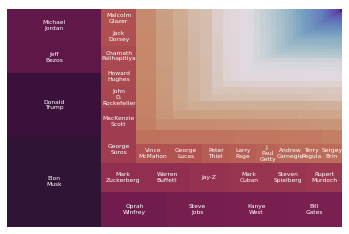

In [82]:
# warning - this one takes a bit to run, but it shouldn't take more than around a minute
# color scheme setup
norm = matplotlib.colors.LogNorm(vmin=min(df.views), vmax=max(df.views))
colors = [matplotlib.cm.twilight_shifted(norm(value)) for value in df.views]

# plot it!
squarify.plot(sizes=df['views'], label=df['person'], alpha=1, text_kwargs={'fontsize':6, 'color':'#FFFFFF'}, color=colors)
plt.axis('off')

plt.show()

![Treemap Zoom](./img/zoom.gif)


## Conclusion
Through our research, we found that certain groups within the billionaires category naturally form clusters in the 3D network graph. We believe this is partly due to some members being a part of a group or organization, which is in turn connected through many other Wikipedia pages, which leads to a higher connectedness between the members of the group. However, this is not universally true. Some groups which are only loosely tied together (such as hedge fund managers) are still clustered in distinct areas within the network graph. Overall, the network graph yielded some fascinating insights, and could likely be further studied extensively, especially if all billionaires within the category were included (though analyzing such a graph would take a long time, and be hard to format in a readable way).

We learned that the billionaires category contains an extremely broad range of page views and the number of links to a page. We also saw some very distinct outliers within the category. Generally, we observed a loose logarithmic correlation between page views and links to page, though we would like to explore this relationship further in the future.

When working on this project, we initially ran into issues with the [Wikipedia API Sandbox](https://en.wikipedia.org/wiki/Special:ApiSandbox#action=query), as it would return different results when compared to our own Wikipedia API queries. This ended up being a result of different default format versions between the python module and the online tool. It took a significant amount of time to figure this out, since we didn’t realize there were multiple format versions in the first place. After realizing this and fixing the issue, we had a mostly smooth project. In terms of ethical or contextual implications for our findings, we do not see any of note. We did not observe any form of Illuminati connections like we had hoped, but then again, that’s what the Illuminati would want you to think...

